# Coevolutionary algorithm
with **GEP** and **Differential Evolution**

The basic idea of a coevolutionary algorithm is as follows: several populations evolve simultaneously, each of which optimizes a given function and has its own optimization strategy. At the same time, the populations "fight" for a resource, which is redistributed in favor of the more effective of them during the operation of the algorithm.

## Params of run
- **Shared resource $N_s$**. The resource $N_s$ is the number of calculations of the objective function - the product of the population size and the number of iterations. Initially, the resource is assumed to be common and is equally divided between each population.
- **Length of the adaptation interval $L_i$**. Setting the adaptation interval value during a certain number of steps (the so-called adaptation interval) each algorithm works separately. The adaptation interval value is determined and set by the researcher. Naturally, its value should not be small (the algorithms will not have time to show themselves) and large (there will be little time for adaptation)
- **Amount of penalty for loss $P$**. The penalty is a certain percentage of the population size of the individual algorithm by which we will reduce the population size of the losing algorithms. Naturally, its value should not be too small (the algorithms will not feel the changes) or large (the search procedure for an algorithm with a small population size becomes meaningless).
- **Size of the "social" card $C_s$**. "Social card" is a certain percentage of the population size of an individual algorithm, which is the minimum guaranteed population size. That is, we can reduce the losing population only until it reaches the minimum guaranteed size - "social card" (the necessity of this limitation has been proven in practice).

## Evaluation of algorithms
Since the coevolutionary algorithm is based on competing strategies of algorithms, a fitness function must be introduced for subpopulations. With the help of this function, the best population is determined and given more opportunities for reproduction.

$\Large q_i=\sum_{k=0}^{L_i-1}\frac{L_i-k}{k+1} \cdot b_i(k)$

where $k=0$ means the current situation, $k=1$ means previous situation, etc; $i$ means index of population; $b_i(k)=1$ if the $i$-th population at time $k$ contains the best (among all populations) individual.

In the future, the obtained assessments of individual algorithms included in the coevolution are the main criterion for assessing the performance of algorithms and are used in the process of resource redistribution.

## Efficiency of the coevolutionary algorithm
The following indicators were used as comparison criteria: reliability $R$ and speed $V$. Reliability $R$ is the number (in percentage) of successful launches of the algorithm out of the total number of launches. Speed $V$ is estimated by the generation number in which the algorithm finds a solution with a given accuracy.

## Run Experiment

### Init params

In [1]:
# shared resource
SHARED_RESOURCE = 30_000

# length of the adaptation interval
ADAPTATION_LENGTH = 15

# amount of penalty for loss
PENALTY = 0.05

# size of population
POPULATION_SIZE = 300

# size of the "social" card
SOCIAL_SIZE = 0.3 * POPULATION_SIZE

# set the seed
SEED = 123

# storage for input regexes params
PARAMS = {}

# storages for test dataset
X, Y = [], []

# number of iterations of performance metric
N_ITER = 100

# stub evaluate value for errros
STUB_VALUE = 1.0

# maximum number of algorithms iterations
POPULATION_NUMBER = 1_000

In [2]:
import random
random.seed(SEED)

In [3]:
import warnings

# nested sets
warnings.simplefilter(action='ignore', category=FutureWarning)

# deap creator
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Prepare Coevolutionary Manager

In [4]:
from typing import Callable

class CoevolutionaryManager:
    
    schema = 'score'
    
    def __init__(
        self,
        verbose: bool = False,
    ):
        self.shared_resources = SHARED_RESOURCE
        self.adaptive_length = ADAPTATION_LENGTH
        self.penalty = PENALTY
        self.social_size = int(SOCIAL_SIZE)
        self.verbose = verbose
        
        self.algorithm_dict = {}
        self.current_winner = None
        self.current_winner_score = STUB_VALUE
        self.winners = []
        
        self.scores_history = {}
        
    def force_winner(self, algorithm_name, algorithm_score):
        self.winners.append(
                (
                    # name
                    algorithm_name, 
                    # score
                    algorithm_score, 
                    # number of population
                    self.algorithm_dict[algorithm_name]['population_number']
                )
            )
        self.current_winner = algorithm_name
        self.current_winner_score = STUB_VALUE
        
    def add_winner(self):
        if self.current_winner:
            self.winners.append(
                (
                    # name
                    self.current_winner, 
                    # score
                    self.current_winner_score, 
                    # number of population
                    self.algorithm_dict[self.current_winner]['population_number']
                )
            )
        self.current_winner = None
        self.current_winner_score = STUB_VALUE
    
    def register_algorithm(self, algorithm_name):
        self.algorithm_dict[algorithm_name] = {
            'individuals': [],
            'population_number': 0,
            'status': 'stop',
            'population_size': POPULATION_SIZE,
            'validation_func': lambda _: True,
            'scores': [],
            'history': [],
            'first_run': True
        }
        self.scores_history[algorithm_name] = []
        
    def add_individual(
        self, 
        algorithm_name,
        individual_str: str,
        individual_metric: float
    ):
        self.algorithm_dict[algorithm_name]['individuals'].append(
            (individual_str, individual_metric)
        )
        
    def get_best_solution(self, algorithm_name):
        minimum_score = STUB_VALUE
        for individual in self.algorithm_dict[algorithm_name]['individuals']:
            if individual[1][0] < minimum_score:
                minimum_score = individual[1][0]
        return minimum_score
        
    def run_population(self, algorithm_name):
        self.algorithm_dict[algorithm_name]['status'] = 'run'
        self.algorithm_dict[algorithm_name]['population_number'] += 1
        
        if self.algorithm_dict[algorithm_name]['population_number'] > self.adaptive_length:
            for algorithm in self.algorithm_dict.keys():
                solution = self.get_best_solution(algorithm_name)
                if solution < self.current_winner_score:
                    self.current_winner_score = solution
                    self.current_winner = algorithm_name
                self.scores_history[algorithm_name].append(solution)
                if self.schema == 'score':
                    score = 0
                    for i in range(self.adaptive_length - 1):
                        try:
                            b = 1 if self.winners[-1*(i+1)] == algorithm_name else 0
                        except IndexError:
                            b = 0
                        score += ((self.adaptive_length - i)/(i+1))
                    self.algorithm_dict[algorithm_name]['score'] = score
                else:
                    raise NotImplementedError
        else:
            if self.algorithm_dict[algorithm_name]['population_number'] > 1:
                solution = self.get_best_solution(algorithm_name)
                if solution < self.current_winner_score:
                    self.current_winner_score = solution
                    self.current_winner = algorithm_name
                self.scores_history[algorithm_name].append(solution)
        if self.algorithm_dict[algorithm_name]['population_number'] > 1:
            print(f'\t#{algorithm_name}# get best metric: <{solution}>')
            self.algorithm_dict[algorithm_name]['history'].append(solution)
            self.algorithm_dict[algorithm_name]['individuals'] = []
        
    def set_validation_function(self, algorithm_name, validation_func):
        self.algorithm_dict[algorithm_name]['validation_func'] = validation_func
        
    def stop_population(self, algorithm_name):
        self.algorithm_dict[algorithm_name]['status'] = 'stop'
        
    def is_adaptive_population(self, algorithm_name):
        return not self.algorithm_dict[algorithm_name]['population_number'] >= self.adaptive_length
    
    def get_resource(self):
        if self.shared_resources:
            self.shared_resources -= 1
            if self.shared_resources % 1000 == 0:
                print(f'--- Remaining resource: {self.shared_resources}')
            return True
        else:
            return False
         
    def get_population(self, population, algorithm_name):
        if self.current_winner == algorithm_name or self.algorithm_dict[algorithm_name]['first_run']:
            print(f'Winner: {algorithm_name}')
            new_population = []
            for el in population:
                new_population.append(el)
        else:
            new_population = []
            population_length = len(population)
            current_length = self.algorithm_dict[algorithm_name]['population_size'] * (1 - self.penalty)
            current_length = int(current_length)
            if current_length < self.social_size:
                current_length = self.social_size
            self.algorithm_dict[algorithm_name]['population_size'] = current_length
            print(f'Looser: {algorithm_name} -- {current_length}')
            for i, el in enumerate(population):
                if len(new_population) == current_length:
                    el = self.algorithm_dict[algorithm_name]['validation_func'](el)
                if el:
                    new_population.append(el)
        if self.algorithm_dict[algorithm_name]['first_run']:
            self.algorithm_dict[algorithm_name]['first_run'] = False
        return new_population
    
    def __repr__(self):
        return '''
        1) <register_algorithm> // register algorithm
            for each population:
            2) <is_adaptive_population> // check nessary to run coevolutionary
            3) <run_population> // send signal about population starting
            if coevolutionary start:
                4) <get_population> // filter population after previous population
                    for each individual:
                    5) <get_resource> // get resource for evaluate individual
                        if resource is available:
                            6) <add_individual> // register individual and his metric
                7) <stop_population> // send signal about population stop
                8) <add_winner> // set the winner 
        '''

### Metrics

In [5]:
import time


class Metrics:
    @staticmethod
    def get_match_accuracy(regex, phrase, result):
        try:
            reg_result = regex.match(phrase).group()
            if reg_result == result:
                return 1
            return 0
        except AttributeError:
            return 0
    
    @staticmethod
    def get_performance_metric(regex, n_iter, test_strings):
        t0 = time.time() * 1000
        for _ in range(n_iter):
            for test_string in test_strings:
                _ = regex.match(test_string)
        return ((time.time() * 1000 - t0) / n_iter) / len(test_strings)    

### Expression Tree to Regular Expression Translator

In [6]:
class ETtoRegexTranslator:
    @staticmethod
    def lexical_analyzer(string):
        sep_symbols = ['(', ')', ',']
        tokens = []
        _current_token = ''
        for symbol in string:
            if symbol in sep_symbols:
                if _current_token != '':
                    tokens.append(_current_token)
                tokens.append(symbol)
                _current_token = ''
            else:
                _current_token += symbol
        return tokens

    @staticmethod
    def generator(tokens, current_state=None):
        global PARAMS
        result = []
        repeat = False
        for i, token in enumerate(tokens):
            if token in TERMINALS:
                # work with special terminals
                if token == 'escape':
                    result.append('\\')
                elif token == 'any':
                    result.append('.')
                elif token == 'range':
                    result.append(f'[{random.choice(PARAMS["range"])}]')
                else:
                    result.append(token)
            # add arguments
            elif token == ',' and current_state == 'alt':
                result.append('|')
            elif token == ')' and repeat is True and current_state is None:
                result.append(f'{"{"}{random.choice(PARAMS["repeat"])}{"}"}')
                repeat = False
            elif token == '(' and current_state in ['group', 'alt']:
                result.append(token)
            elif token == ')':
                current_state = None
                result.append(')')
            # check functions
            elif token == 'group':
                current_state = 'group'
            elif token == 'repeat':
                repeat = True
            elif token == 'alt':
                current_state = 'alt'
        return result
    
    @staticmethod
    def regex_compile(individual):
        individual = re.sub(
            r'\s', 
            '', 
            str(individual)
        )
        tokens = ETtoRegexTranslator.lexical_analyzer(individual)
        regex = ''.join(
            ETtoRegexTranslator.generator(tokens)
        ) + ')'
        try:
            return re.compile(regex), None
        except Exception as e:
            return None, f'error: {e}, string: {regex}'

### Incidence List to Regular Expression Translator

In [7]:
import re
from enum import Enum


class NodesTypes(Enum):
    params = -1
    seq = 0
    atom = 1
    any = 2
    repeat = 3
    alt = 4
    altgroup = 5
    group = 6
    range = 7
    escape = 8

class Nodes:
    nodes_types = {}
    max_id = 0

    def __init__(self):
        for node_type in NodesTypes.__members__:
            value = NodesTypes.__members__.get(node_type).value
            self.nodes_types[value] = node_type
            self.max_id = value

class ILtoRegexTranslator:
    def __init__(self, incidence_list, nodes, params):
        self.params = params
        self.incidence_list = incidence_list
        self.nodes = nodes

    @staticmethod
    def preprocess_incidence_list(incidence_list):
        previous_incidence = incidence_list[0]
        new_incidence_list = [previous_incidence[0], previous_incidence[1]]

        for incidence in incidence_list[1:]:
            if incidence[0] == incidence[1] == 0:
                new_incidence_list.append(-1)
                continue
            if previous_incidence[1] == incidence[0]:
                new_incidence_list.append(incidence[1])
                previous_incidence = incidence
                continue
            else:
                new_incidence_list.append(incidence[0])
                new_incidence_list.append(incidence[1])
                previous_incidence = incidence

        return new_incidence_list
    
    def get_regex(self, incidence_list):

        regex = ''

        is_alt = False
        is_group = False
        is_repeat = False

        for incidence in incidence_list:
            if incidence[0] == 0 and is_group:
                regex += ')'
            if incidence[0] == 3:
                continue
            match incidence[1]:
                case 0:
                    if incidence[0] == 0:
                        continue
                case 2:
                    regex += '.'
                case 3:
                    if not is_repeat:
                        is_repeat = True
                    continue
                case 5:
                    if is_alt:
                        regex += '|'
                        is_alt = False
                    else:
                        is_alt = True
                case 6:
                    regex += '('
                    is_group = True
                case 7:
                    _params = self.params.get('range')[0]
                    regex += f'[{_params}]'
                case 8:
                    regex += '\\'
                case _:
                    if incidence[0] in [1, 8]:
                        regex += self.nodes[incidence[1]]
            if is_repeat:
                _params = self.params.get('repeat')[0]
                regex += f'{_params}'
                is_repeat = False
        return regex
    
    def regex_compile(self, individual):
        try:
            return re.compile(self.get_regex(individual)), None
        except Exception as e:
            return None, e

### GEP class

In [8]:
import re
import random
from typing import List, Dict, Callable

import exrex
import geppy
import numpy as np
from deap import creator, base, tools


def regex_process(string, regex):
    re_comp = re.compile(regex)
    try:
        return re_comp.match(string).group()
    except AttributeError:
        return None


class GEPAlgorithm:
    
    _statistics_dict = {
        "avg": np.mean,
        "std": np.std,
        "min": np.min,
        "max": np.max
    }
    
    _seed = SEED
    _verbose = True
    
    def __init__(
        self,
        head_n: int,
        genes_n: int,
        terminals: List,
        functions: Dict,
        evaluate_function: Callable,
        population_size: int,
        population_number: int,
        n_elites: int,
    ):
        # init entities for algorithm
        self.terminals = terminals
        self.functions = functions
        
        # init GEP variables
        self.head_n = head_n
        self.genes_n = genes_n
        
        # test strings for check accuracy
        self.test_strings = []
        
        # X and Y for test dataset
        self.X = []
        self.Y = []
        
        # set evaluate function
        self.evaluate_function = evaluate_function
        
        # set the evolution params
        self.population_size = population_size
        self.population_number = population_number
        self.n_elites = n_elites
             
    @staticmethod
    def get_test_strings(
        input_regex: str,
        n_fuzzy_strings: int,
    ):
        return list(
            exrex.generate(
                input_regex, 
                limit=n_fuzzy_strings)
        )
    
    @staticmethod
    def create_training_set(
        test_strings: List,
        original_regex: str,
        process_func: Callable
    ):
        Y = []
        X = []
        for string in test_strings:
            X.append(string)
            Y.append(
                process_func(
                    string=string, 
                    regex=original_regex
                )
            )
        return X, Y
    
    def create_primitives_set(self):
        # terminals
        pset = geppy.PrimitiveSet('Main', input_names=self.terminals)

        # functions
        for function in self.functions.keys():
            pset.add_function(function, self.functions.get(function))
        return pset
    
    @staticmethod
    def create_individual():
        # to minimize the objective (fitness)
        creator.create("FitnessMin", base.Fitness, weights=(-1,))
        creator.create("Individual", geppy.Chromosome, fitness=creator.FitnessMin)
        return creator
    
    @staticmethod
    def create_popiulation(
        pset,
        creator,
        head_length: int = 5,
        genes_number_in_chromosome: int = 2,
    ):
        toolbox = geppy.Toolbox()
        toolbox.register('gene_gen', geppy.Gene, pset=pset, head_length=head_length)
        toolbox.register(
            'individual', 
            creator.Individual, 
            gene_gen=toolbox.gene_gen, 
            n_genes=genes_number_in_chromosome,
            linker=group
        )
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register('compile', geppy.compile_, pset=pset)
        return toolbox
    
    def set_evalute_function(self, toolbox):
        toolbox.register('evaluate', self.evaluate_function)
        return toolbox
        
    def set_genetic_operators(self, toolbox, pset):
        toolbox.register('select', tools.selRoulette)
        ## general mutations whose aliases start with 'mut'
        # We can specify the probability for an operator with the .pbs property
        toolbox.register(
            'mut_uniform', 
            geppy.mutate_uniform, 
            pset=pset, 
            ind_pb=2 / (2 * self.head_n + 1)
        )
        toolbox.pbs['mut_uniform'] = 0.5
        # Alternatively, assign the probability along with registration using the pb keyword argument.
        toolbox.register('mut_invert', geppy.invert, pb=0.1)
        toolbox.register('mut_is_ts', geppy.is_transpose, pb=0.1)
        toolbox.register('mut_ris_ts', geppy.ris_transpose, pb=0.1)
        toolbox.register('mut_gene_ts', geppy.gene_transpose, pb=0.4)

        ## general crossover whose aliases start with 'cx'
        toolbox.register('cx_1p', geppy.crossover_one_point, pb=0.3)
        toolbox.pbs['cx_1p'] = 0.4   # just show that the probability can be overwritten
        toolbox.register('cx_2p', geppy.crossover_two_point, pb=0.2)
        toolbox.register('cx_gene', geppy.crossover_gene, pb=0.1)
        
        return toolbox
        
    def set_statistic(self):
        stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
        for statistic_name in self._statistics_dict.keys():
            stats.register(
                statistic_name, 
                self._statistics_dict[statistic_name]
            )
        return stats

#### Prepare terminals

In [9]:
import unicodedata
from geppy.core.symbol import _is_nonkeyword_identifier

def get_all_unicode_letters(start_code, stop_code):
    start_idx, stop_idx = [int(code, 16) for code in (start_code, stop_code)]
    characters = []
    for unicode_idx in range(start_idx, stop_idx + 1):
        characters.append(chr(unicode_idx))
    return characters

TERMINALS = []

# Latin lower
# TERMINALS += get_all_unicode_letters('0061', '007A')
TERMINALS += ['a', 'b', 'c']

# digits
TERMINALS += get_all_unicode_letters('0030', '0039')

# special symbols
TERMINALS += '['

# check ability to get __name__
correct_terminals = []

for x in TERMINALS:
    try:
        assert _is_nonkeyword_identifier(x)
        correct_terminals.append(x)
    except Exception as e:
        pass
    
TERMINALS = correct_terminals

# range group and escape in this work will be terminals
TERMINALS += ['range', 'any', 'escape']

#### Prepare functions

In [10]:
# dummy functions for naming
def alt(*args):
    return args
    
def group(*args):
    return args

def repeat(*args):
    return args

# Key - function object
# Value - arity of function
FUNCTIONS = {
    alt: 2,
    group: 10,
    repeat: 1,
}

#### Prepare evaluation function

In [11]:
def gep_evaluate(individual):
    global X, Y
    res = ETtoRegexTranslator.regex_compile(individual)
    if not res[0]:
        try:
            individual = '(' + individual
            res = ETtoRegexTranslator.regex_compile(individual)
        except:
            return STUB_VALUE,
    
    regex = res[0]
    # count accuracy metric
    accuracy = []
    for x, y in zip(X, Y):
        accuracy.append(
            Metrics.get_match_accuracy(
                regex=regex, 
                phrase=x, 
                result=y
            )
        )
    try:
        accuracy = sum(accuracy)/len(accuracy)
        res_metric = float(
            Metrics.get_performance_metric(
                regex=regex,
                n_iter=N_ITER,
                test_strings=X
        )) / accuracy
    except ZeroDivisionError:
        res_metric = STUB_VALUE

    return res_metric,

#### prepare visualization of best

In [12]:
from IPython.display import Image

rename_labels = {
    'group': 'group', 
    'alt': 'alt', 
    'repeat': 'repeat', 
    'escape': 'escape', 
    '_range': 'range'
}

def visualize(ind):
    geppy.export_expression_tree(ind, rename_labels, 'data/coevolutionary_tree.png')

### DE class

In [13]:
import re
import array
import random
from typing import List, Dict, Callable

import exrex
import numpy as np
from deap import creator, base, tools


def regex_process(string, regex):
    re_comp = re.compile(regex)
    try:
        return re_comp.match(string).group()
    except AttributeError:
        return None


class DEAlgorithm:
    
    _statistics_dict = {
        "avg": np.mean,
        "std": np.std,
        "min": np.min,
        "max": np.max
    }
    
    _de_dict = {
        'cr': 0.5,
        'f': 0.1,
        'mu': POPULATION_SIZE,
    }
    
    _verbose = True
    _seed = SEED
    
    def __init__(
        self,
        bounds,
        ndim,
        evaluate_function: Callable,
        population_size: int,
        population_number: int,
    ):
        # de params
        self.bounds = bounds
        self.ndim = ndim
        
        # evolution params
        self.population_size = population_size
        self.population_number = population_number
        
        # test strings for check accuracy
        self.test_strings = []
        
        # X and Y for test dataset
        self.X = []
        self.Y = []
        
        # evaluate function
        self.evaluate_function = evaluate_function
        
    @staticmethod
    def get_test_strings(
        input_regex: str,
        n_fuzzy_strings: int,
    ):
        return list(
            exrex.generate(
                input_regex, 
                limit=n_fuzzy_strings)
        )
        
    @staticmethod
    def create_training_set(
        test_strings: List,
        original_regex: str,
        process_func: Callable
    ):
        Y = []
        X = []
        for string in test_strings:
            X.append(string)
            Y.append(
                process_func(
                    string=string, 
                    regex=original_regex
                )
            )
        return X, Y
    
    def set_genetic_operators(self):
        
        toolbox = base.Toolbox()
        toolbox.register("attr_float", random.uniform, 0, 12)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, self.ndim)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("select", tools.selRandom, k=3)
        
        return toolbox
        
    @staticmethod
    def create_individual():
        # to minimize the objective (fitness)
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)
        return creator
    
    def set_evalute_function(self, toolbox):
        toolbox.register('evaluate', self.evaluate_function)
        return toolbox
    
    def set_statistic(self):
        stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
        for statistic_name in self._statistics_dict.keys():
            stats.register(
                statistic_name, 
                self._statistics_dict[statistic_name]
            )
        return stats
    
    def create_popiulation(self, toolbox):
        pop = toolbox.population(n=self._de_dict['mu']);
        return pop

#### Prepare evaluation function

In [14]:
from typing import List
_translator = None


def de_evaluate(individual):
    
    if not isinstance(individual, List):
        individual = individual.tolist()
    
    individual = np.array(
        [abs(x) for x in individual]
    ).round().reshape((-1, 2))
    
    global X, Y
    
    res = _translator.regex_compile(individual)
    regex = res[0]
    if not regex:
        return STUB_VALUE,
    
    # count accuracy metric
    accuracy = []
    for x, y in zip(X, Y):
        accuracy.append(
            Metrics.get_match_accuracy(
                regex=regex, 
                phrase=x, 
                result=y
            )
        )
    try:
        accuracy = sum(accuracy)/len(accuracy)
        res_metric = float(
            Metrics.get_performance_metric(
                regex=regex,
                n_iter=N_ITER,
                test_strings=X
        )) / accuracy
    except ZeroDivisionError:
        res_metric = STUB_VALUE

    return res_metric,

### Run

In [15]:
def clean_globals():
    global PARAMS, X, Y
    X, Y = [], []
    PARAMS = {}  
    
def set_globals():
    global PARAMS, NODES, _translator
    PARAMS = {
        'range': ['0-9'],
        'repeat': ['0,1']
    }
    
    NODES = {
        # functions (except any)
        -1: 'params', 
        0: 'seq', 
        1: 'atom', 
        2: 'any', 
        3: 'repeat', 
        4: 'alt', 
        5: 'altgroup', 
        6: 'group', 
        7: 'range', 
        8: 'escape', 
        
        # terminals (get by input regex)
        9: 'a', 
        10: 'b', 
        11: 'c', 
        12: '['
    }

    _translator = ILtoRegexTranslator(
        incidence_list = [(0, 4), (4, 5), (5, 1), (1, 9), (5, 3), 
                          (3, 1), (1, 10), (5, 1), (1, 11), (5, 2), 
                          (4, 5), (5, 7), (5, 8), (8, 12)],
        nodes = NODES,
        params = PARAMS
    )

#### Prepare coevolutionary function

In [16]:
import deap
import random
import warnings

history = {
    'gep': [],
    'de': []
}


def _validate_basic_toolbox(tb):
    assert hasattr(tb, 'select'), "The toolbox must have a 'select' operator."
    # whether the ops in .pbs are all registered
    for op in tb.pbs:
        assert op.startswith('mut') or op.startswith('cx'), \
        "Operators must start with 'mut' or 'cx' except selection."
        assert hasattr(tb, op), "Probability for a operator called '{}' \
        is specified, but this operator is not " \
                                "registered in the toolbox.".format(op)
    # whether all the mut_ and cx_ operators have their probabilities assigned in .pbs
    for op in [attr for attr in dir(tb) if attr.startswith('mut') or attr.startswith('cx')]:
        if op not in tb.pbs:
            warnings.warn('{0} is registered, \
            but its probability is NOT assigned in Toolbox.pbs. '
                          'By default, \
                          the probability is ZERO and the operator {0} will NOT be applied.'.format(op),
                          category=UserWarning)


def _apply_modification(population, operator, pb):
    for i in range(len(population)):
        if random.random() < pb:
            population[i], = operator(population[i])
            del population[i].fitness.values
    return population


def _apply_crossover(population, operator, pb):
    for i in range(1, len(population), 2):
        if random.random() < pb:
            population[i - 1], population[i] = operator(population[i - 1], population[i])
            del population[i - 1].fitness.values
            del population[i].fitness.values
    return population


def run_coevolutionary(
    # populations
    population_gep, 
    population_de, 
    
    # stats
    stats_de,
    stats_gep,
    
    # toolboxes
    toolbox_de,
    toolbox_gep,
    
    # params for all
    n_generations=100, 
    verbose=__debug__,
    
    # params for gep
    n_elites=1,
    
    # params for de
    ndim=15,
    bounds=[0,8],
    de_params={
        'cr': 0.5,
        'f': 0.4,
        'mu': POPULATION_SIZE,
    },
    
    # skip algorithms
    _skip_de = False,
    _skip_gep = False,
):
    # init
    if _skip_de:
        hof_de = None
        logbook_de = None
        
    if _skip_gep:
        hof_gep = None
        logbook_gep = None
    
    def validate_ind_gep(ind):
        return None
    
    def validate_ind_de(ind):
        return None
    
    ## for coevolutionary (step 1)
    if not _skip_gep:
        ce_manager.register_algorithm('gep')
        ce_manager.set_validation_function(
            algorithm_name='gep',
            validation_func=validate_ind_gep
        )
        _validate_basic_toolbox(toolbox_gep)
    if not _skip_de:
        ce_manager.register_algorithm('de')
        ce_manager.set_validation_function(
            algorithm_name='de',
            validation_func=validate_ind_de
        )
        # init de individuals
        fitnesses_de = toolbox_de.map(toolbox_de.evaluate, population_de)
        for ind, fit in zip(population_de, fitnesses_de):
            ind.fitness.values = fit
    ##
    
    # prepare calculating statistics and logs
    if not _skip_de:
        logbook_de = deap.tools.Logbook()
    if not _skip_gep:
        logbook_gep = deap.tools.Logbook()
    
    # loggers
    base_logbook = ['gen', 'nevals']
    if not _skip_de:
        logbook_de.header = base_logbook + (stats_de.fields if stats_de else [])
    if not _skip_gep:
        logbook_gep.header = base_logbook + (stats_gep.fields if stats_gep else [])
    
    # halls of fame
    if not _skip_de:
        hof_de = tools.HallOfFame(1)
    if not _skip_gep:
        hof_gep = tools.HallOfFame(1)
    
    ## for coevolutionary (step 2)
    is_adaptive_population = True
    is_adaptive_population_de = False
    is_adaptive_population_gep = False
    ##
    
    if not _skip_gep:
        invalid_individuals_gep = population_gep
    if not _skip_de:
        invalid_individuals_de = population_de
    

    for gen in range(n_generations + 1):
        
        ## for coevolutionary (step 2)
        if not _skip_de:
            is_adaptive_population_de = ce_manager.is_adaptive_population('de')
        if not _skip_gep:
            is_adaptive_population_gep = ce_manager.is_adaptive_population('gep')
        ##
        
        ## for coevolutionary (step 3)
        if not _skip_gep:
            ce_manager.run_population('gep')
        if not _skip_de:
            ce_manager.run_population('de')
        ##
        
        is_adaptive_population = is_adaptive_population_de * is_adaptive_population_gep
        
        ## for coevolutionary (step 4)
        if not is_adaptive_population:
            if not _skip_gep:
                invalid_individuals_gep = ce_manager.get_population(
                    population=invalid_individuals_gep,
                    algorithm_name='gep'
                )
            if not _skip_de:
                invalid_individuals_de = ce_manager.get_population(
                    population=invalid_individuals_de,
                    algorithm_name='de'
                )
        ##       
        
        if not _skip_de:
            print(f'\t#de# Size of population: <{len(invalid_individuals_de)}>')
        if not _skip_gep:
            print(f'\t#gep# Size of population: <{len(invalid_individuals_gep)}>')
        
        ind_errors = [0, 0]
        ind_calculates = [0, 0]
        is_end = False
        
        ## GEP ##
        if not _skip_gep:
            # evaluates
            for ind in invalid_individuals_gep:
                ind.fitness.values = toolbox_gep.evaluate(ind)
                ## for coevolutionary (step 5)
                if ce_manager.get_resource():
                    try:
                        ## for coevolutionary (step 6)
                        ce_manager.add_individual(
                            algorithm_name='gep',
                            individual_str=ind,
                            individual_metric=ind.fitness.values
                        )
                        ind_calculates[0] += 1
                    except Exception as e:
                        ind_errors[0] += 1
                else:
                    is_end = True
                    break
                ##
        
            if is_end:
                break

            # erros after population run
            if ind_errors[0]:
                print(f'\t#gep# Errors percent while fitness calculations: '
                      f'{round(ind_errors[0]/(ind_errors[0]+ind_calculates[0]),3)*100}%')
        
            # record statistics
            record_gep = stats_gep.compile(invalid_individuals_gep) if stats_gep else {}
            # logs
            logbook_gep.record(gen=gen, nevals=len(invalid_individuals_gep), **record_gep)
            
            # save best
            if hof_gep is not None:
                hof_gep.update(invalid_individuals_gep)
    
            # selection with elitism
            elites = deap.tools.selBest(invalid_individuals_gep, k=n_elites)
            offspring = toolbox_gep.select(invalid_individuals_gep, len(invalid_individuals_gep) - n_elites)
            # replication
            offspring = [toolbox_gep.clone(ind) for ind in offspring]
            # mutation
            for op in toolbox_gep.pbs:
                if op.startswith('mut'):
                    offspring = _apply_modification(
                        offspring, 
                        getattr(toolbox_gep, op), 
                        toolbox_gep.pbs[op]
                    )
            # crossover
            for op in toolbox_gep.pbs:
                if op.startswith('cx'):
                    offspring = _apply_crossover(offspring, getattr(toolbox_gep, op), toolbox_gep.pbs[op])
            # replace the current population with the offsprings
            invalid_individuals_gep = elites + offspring
        
        ## DE ##
        if not _skip_de:
            # operators
            for k, agent in enumerate(invalid_individuals_de):
                a,b,c = toolbox_de.select(invalid_individuals_de)
                y = toolbox_de.clone(agent)
                index = random.randrange(ndim)
                for i, value in enumerate(agent):
                    if i == index or random.random() < de_params['cr']:
                        y[i] = a[i] + de_params['f']*(b[i]-c[i])
                if ce_manager.get_resource():
                    y.fitness.values = toolbox_de.evaluate(y)

                    ## for coevolutionary (step 6)
                    ce_manager.add_individual(
                        algorithm_name='de',
                        individual_str=y,
                        individual_metric=y.fitness.values
                    )

                    if y.fitness > agent.fitness:
                        population_de[k] = y
                else:
                    is_end = True
                    break
            
            if is_end:
                break

            if ind_errors[1]:
                print(f'\t#de# Errors percent while fitness calculations: '
                      f'{round(ind_errors[1]/(ind_errors[1]+ind_calculates[1]),3)*100}%')

            if hof_de is not None:
                hof_de.update(invalid_individuals_de)

            record_de = stats_de.compile(invalid_individuals_de) if stats_de else {}

            logbook_de.record(gen=gen, nevals=len(invalid_individuals_de), **record_de)
        
        if verbose:
            if not _skip_de:
                print(f'#de# {logbook_de.stream}')
            if not _skip_gep:
                print(f'#gep# {logbook_gep.stream}')
        
        if not _skip_de:
            history['de'].append(logbook_de.pop())
        if not _skip_gep:
            history['gep'].append(logbook_gep.pop())
        
        if _skip_gep or _skip_de:
            ce_manager.force_winner(
                algorithm_name='de' if _skip_gep else 'gep',
                algorithm_score=ce_manager.get_best_solution(
                    'de' if _skip_gep else 'gep'
                )
            )
        else:
                    ## for coevolutionary (step 7)
            if not _skip_gep:
                ce_manager.stop_population('gep')
            if not _skip_de:
                ce_manager.stop_population('de')
            ##
            ## for coevolutionary (step 8)
            ce_manager.add_winner()
            ##
        
    return hof_gep, hof_de, logbook_de, logbook_gep

#### Prepare population and stats for algorithms

In [17]:
set_globals()
ce_manager = CoevolutionaryManager()

gep = GEPAlgorithm(
    terminals=TERMINALS,
    functions=FUNCTIONS,
    head_n=3,
    genes_n=2,
    evaluate_function=gep_evaluate,
    population_size=POPULATION_SIZE,
    population_number=POPULATION_NUMBER,
    n_elites=4
)

input_regex = 'ab?c.|[0-9]\['

test_strings = gep.get_test_strings(
    input_regex=input_regex,
    n_fuzzy_strings=5
)

## GEP ##

gep.X, gep.Y = gep.create_training_set(
    test_strings=test_strings,
    original_regex=input_regex,
    process_func=regex_process,
)

global X, Y
X = gep.X
Y = gep.Y
        
pset = gep.create_primitives_set()

creator_gep = gep.create_individual()

toolbox_gep = gep.create_popiulation(
    pset=pset,
    creator=creator_gep,
    head_length=gep.head_n,
    genes_number_in_chromosome=gep.genes_n,
)

toolbox_gep = gep.set_evalute_function(toolbox_gep)

toolbox_gep = gep.set_genetic_operators(
    toolbox=toolbox_gep, 
    pset=pset,
)

population_gep = toolbox_gep.population(
    n=gep.population_size
)

stats_gep = gep.set_statistic()

## DE ##

de = DEAlgorithm(
    bounds=[0, 11],
    ndim=14 * 2,
    evaluate_function=de_evaluate,
    population_size=POPULATION_SIZE,
    population_number=POPULATION_NUMBER,
)

creator_de = de.create_individual()
        
toolbox_de = de.set_genetic_operators()

population_de = de.create_popiulation(toolbox_de)

toolbox_de = de.set_evalute_function(toolbox_de)

stats_de = de.set_statistic()

In [18]:
hof_gep, hof_de, _, _ = run_coevolutionary(
    # populations
    population_gep=population_gep, 
    population_de=population_de, 
    
    # stats
    stats_de=stats_de,
    stats_gep=stats_gep,
    
    # toolboxes
    toolbox_de=toolbox_de,
    toolbox_gep=toolbox_gep,
    
    n_generations=POPULATION_NUMBER,
)

	#de# Size of population: <300>
	#gep# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
0  	300   	0.993351	0.0811607	0.00233154	1  
#gep# gen	nevals	avg     	std     	min       	max
0  	300   	0.973475	0.160255	0.00203198	1  
	#gep# get best metric: <0.002031982421875>
	#de# get best metric: <0.0023315429687499997>
	#de# Size of population: <300>
	#gep# Size of population: <300>
--- Remaining resource: 29000
#de# gen	nevals	avg     	std      	min       	max
1  	300   	0.986704	0.114375 	0.00233154	1  
#gep# gen	nevals	avg     	std     	min       	max
1  	300   	0.983502	0.126733	0.00199023	1  
	#gep# get best metric: <0.001990234375>
	#de# get best metric: <0.0027568359375>
	#de# Size of population: <300>
	#gep# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
2  	300   	0.980057	0.139602 	0.00233154	1  
#gep# gen	nevals	avg     	std     	min        	max
2  	300   	0.986696	0.114443	0.000359531	1  
	#gep# get best metric: <0.000359

#de# gen	nevals	avg     	std      	min        	max
22 	218   	0.922237	0.267392 	0.000295196	1  
#gep# gen	nevals	avg     	std      	min        	max
22 	285   	0.9895  	0.1018   	0.000349014	1  
	#gep# get best metric: <0.0003490137791895605>
	#de# get best metric: <1.0>
Winner: gep
Looser: de -- 207
	#de# Size of population: <207>
	#gep# Size of population: <285>
#de# gen	nevals	avg     	std      	min        	max
23 	207   	0.918104	0.273787 	0.000295196	1  
#gep# gen	nevals	avg     	std      	min        	max
23 	285   	0.99309 	0.0822105	0.000356928	1  
	#gep# get best metric: <0.000356928228021978>
	#de# get best metric: <1.0>
Winner: gep
Looser: de -- 196
	#de# Size of population: <196>
	#gep# Size of population: <285>
--- Remaining resource: 16000
#de# gen	nevals	avg     	std      	min        	max
24 	196   	0.923683	0.265103 	0.000295196	1  
#gep# gen	nevals	avg     	std      	min        	max
24 	285   	0.979078	0.142678 	0.000333936	1  
	#gep# get best metric: <0.000333936083447

#de# gen	nevals	avg     	std      	min        	max
44 	90    	0.944593	0.228449 	0.000295196	1  
#gep# gen	nevals	avg     	std      	min        	max
44 	285   	0.979122	0.142382 	0.000294069	1  
	#gep# get best metric: <0.00029406872424450554>
	#de# get best metric: <1.0>
Winner: gep
Looser: de -- 90
	#de# Size of population: <90>
	#gep# Size of population: <285>
#de# gen	nevals	avg     	std      	min        	max
45 	90    	0.944593	0.228449 	0.000295196	1  
#gep# gen	nevals	avg     	std      	min        	max
45 	285   	0.986003	0.117314 	0.000309898	1  
	#gep# get best metric: <0.0003098976219093407>
	#de# get best metric: <0.003156005859375>
Winner: gep
Looser: de -- 90
	#de# Size of population: <90>
	#gep# Size of population: <285>
--- Remaining resource: 7000
#de# gen	nevals	avg     	std      	min        	max
46 	90    	0.944593	0.228449 	0.000295196	1  
#gep# gen	nevals	avg     	std      	min        	max
46 	285   	0.982594	0.130264 	0.000285269	1  
	#gep# get best metric: <0.0002

In [19]:
best_gep = hof_gep[0]
best_de = hof_de[0]

In [20]:
ce_manager.winners

[('gep', 0.002031982421875, 2),
 ('gep', 0.001990234375, 3),
 ('gep', 0.00035953060611263734, 4),
 ('gep', 0.00034649188701923084, 5),
 ('gep', 0.0003371286916208791, 6),
 ('gep', 0.0003543795072115385, 7),
 ('gep', 0.00036022815075549455, 8),
 ('gep', 0.00035767942994505494, 9),
 ('gep', 0.0003694840315934066, 10),
 ('de', 0.0002951955271291209, 11),
 ('gep', 0.00035926231971153844, 12),
 ('gep', 0.00037085229223901095, 13),
 ('gep', 0.00036151592548076925, 14),
 ('gep', 0.00034992595295329674, 15),
 ('de', 0.0002894541981456044, 16),
 ('gep', 0.00035000643887362644, 17),
 ('de', 0.0002738667582417582, 18),
 ('gep', 0.0003341775412087912, 19),
 ('gep', 0.0003663719093406594, 20),
 ('gep', 0.0003343921703296703, 21),
 ('gep', 0.0003606574089972528, 22),
 ('gep', 0.00035990620707417585, 23),
 ('gep', 0.0003490137791895605, 24),
 ('gep', 0.000356928228021978, 25),
 ('gep', 0.0003339360834478022, 26),
 ('gep', 0.0003267133353960396, 27),
 ('gep', 0.00036466390779702976, 28),
 ('gep', 0.00

#### see the evaluate metric for best by GEP

In [21]:
ETtoRegexTranslator.regex_compile(best_gep)

(re.compile(r'(a((c).{0,1}))', re.UNICODE), None)

In [22]:
gep_evaluate(best_gep)

(0.0002728472699175824,)

#### see the strucutre of best by GEP

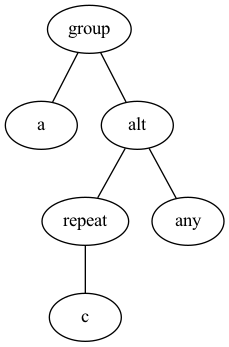

In [23]:
visualize(best_gep)
Image(filename='data/coevolutionary_tree.png')

#### see the evaluate metric for best by DE

In [24]:
de_evaluate(best_de)

(0.0003294557005494505,)

#### see the strucutre of best by DE

In [25]:
best_de = np.array(
        [abs(x) for x in best_de.tolist()]
    ).round().reshape((-1, 2))

_translator.regex_compile(best_de)

(re.compile(r'...', re.UNICODE), None)

## Results

In [26]:
coev_winners_history = ce_manager.winners

In [27]:
coev_gep_history = ce_manager.algorithm_dict['gep']['history']

In [28]:
coev_de_history = ce_manager.algorithm_dict['de']['history']

## Run only DE

In [29]:
set_globals()
ce_manager = CoevolutionaryManager()

de = DEAlgorithm(
    bounds=[0, 11],
    ndim=15 * 2,
    evaluate_function=de_evaluate,
    population_size=POPULATION_SIZE,
    population_number=POPULATION_NUMBER,
)

creator_de = de.create_individual()
    
toolbox_de = de.set_genetic_operators()

population_de = de.create_popiulation(toolbox_de)

toolbox_de = de.set_evalute_function(toolbox_de)

stats_de = de.set_statistic()

In [30]:
_, hof_de, _, _ = run_coevolutionary(
    # populations
    population_gep=None, 
    population_de=population_de, 
    
    # stats
    stats_de=stats_de,
    stats_gep=None,
    
    # toolboxes
    toolbox_de=toolbox_de,
    toolbox_gep=None,
    
    n_generations=POPULATION_NUMBER,
    
    _skip_gep = True
)

Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
0  	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.001965087890625>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
1  	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.00037232786744505496>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
2  	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <1.0>
Winner: de
	#de# Size of population: <300>
--- Remaining resource: 29000
#de# gen	nevals	avg     	std      	min       	max
3  	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.00031099759615384615>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
4  	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.003365966796875>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	s

#de# gen	nevals	avg     	std      	min       	max
44 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.0002645035628434066>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
45 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.0003642792754120879>
Winner: de
	#de# Size of population: <300>
--- Remaining resource: 16000
#de# gen	nevals	avg     	std      	min       	max
46 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.002093994140625>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
47 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.002303955078125>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
48 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.0031799316406249997>
Winner: de
	#de# Size of population: <300>
--- Remaining resource: 15000
#de# gen	nevals	avg    

#de# gen	nevals	avg     	std      	min       	max
87 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.00040943187671703304>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
88 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.002375>
Winner: de
	#de# Size of population: <300>
--- Remaining resource: 3000
#de# gen	nevals	avg     	std      	min       	max
89 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <1.0>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
90 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.0021633300781249997>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
91 	300   	0.996677	0.0574664	0.00298926	1  
	#de# get best metric: <0.00234326171875>
Winner: de
	#de# Size of population: <300>
#de# gen	nevals	avg     	std      	min       	max
92 	300   	0.996677	0.0574664	0

In [31]:
only_de_history = ce_manager.algorithm_dict['de']['history']

## Run only GEP

In [32]:
set_globals()
ce_manager = CoevolutionaryManager()

gep = GEPAlgorithm(
    terminals=TERMINALS,
    functions=FUNCTIONS,
    head_n=4,
    genes_n=3,
    evaluate_function=gep_evaluate,
    population_size=POPULATION_SIZE,
    population_number=POPULATION_NUMBER,
    n_elites=4
)

gep.X, gep.Y = gep.create_training_set(
    test_strings=test_strings,
    original_regex=input_regex,
    process_func=regex_process,
)

global X, Y
X = gep.X
Y = gep.Y
        
pset = gep.create_primitives_set()

creator_gep = gep.create_individual()

toolbox_gep = gep.create_popiulation(
    pset=pset,
    creator=creator_gep,
    head_length=gep.head_n,
    genes_number_in_chromosome=gep.genes_n,
)

toolbox_gep = gep.set_evalute_function(toolbox_gep)

toolbox_gep = gep.set_genetic_operators(
    toolbox=toolbox_gep, 
    pset=pset,
)

population_gep = toolbox_gep.population(
    n=gep.population_size
)

stats_gep = gep.set_statistic()

In [33]:
hof_gep, _, _, _ = run_coevolutionary(
    # populations
    population_gep=population_gep, 
    population_de=None, 
    
    # stats
    stats_de=None,
    stats_gep=stats_gep,
    
    # toolboxes
    toolbox_de=None,
    toolbox_gep=toolbox_gep,
    
    n_generations=POPULATION_NUMBER,
    
    _skip_de = True
)

Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg   	std     	min       	max
0  	300   	0.9703	0.168896	0.00188372	1  
	#gep# get best metric: <0.0018837193080357142>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std     	min        	max
1  	300   	0.963744	0.185855	0.000335143	1  
	#gep# get best metric: <0.0003351433722527473>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std     	min        	max
2  	300   	0.986791	0.113636	0.000337719	1  
	#gep# get best metric: <0.00033771892170329673>
Winner: gep
	#gep# Size of population: <300>
--- Remaining resource: 29000
#gep# gen	nevals	avg     	std     	min        	max
3  	300   	0.983451	0.127118	0.000335197	1  
	#gep# get best metric: <0.0003351970295329671>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std      	min        	max
4  	300   	0.990015	0.0993538	0.000352287	1  
	#gep# get best metric: <0.0003522868732829671>
Winner: gep
	#gep# Size of p

#gep# gen	nevals	avg     	std      	min        	max
41 	300   	0.993428	0.0802346	0.000253584	1  
	#gep# get best metric: <0.0002535843063186813>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std      	min        	max
42 	300   	0.986756	0.113938 	0.000254094	1  
	#gep# get best metric: <0.0002540940504807692>
Winner: gep
	#gep# Size of population: <300>
--- Remaining resource: 17000
#gep# gen	nevals	avg     	std      	min        	max
43 	300   	0.986776	0.113762 	0.000255033	1  
	#gep# get best metric: <0.0002550330528846154>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std      	min        	max
44 	300   	0.983457	0.127079 	0.000212924	1  
	#gep# get best metric: <0.0002129236857096354>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std      	min        	max
45 	300   	0.986718	0.114261 	0.000221303	1  
	#gep# get best metric: <0.00022130330403645831>
Winner: gep
	#gep# Size of population: <300>
--- Remaining 

#gep# gen	nevals	avg     	std      	min        	max
82 	300   	0.980427	0.137017 	0.000203079	1  
	#gep# get best metric: <0.0002030793913118132>
Winner: gep
	#gep# Size of population: <300>
--- Remaining resource: 5000
#gep# gen	nevals	avg     	std      	min        	max
83 	300   	0.967049	0.17746  	0.000216936	1  
	#gep# get best metric: <0.00021693638392857143>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std      	min        	max
84 	300   	0.986856	0.113101 	0.000218023	1  
	#gep# get best metric: <0.000218022943853022>
Winner: gep
	#gep# Size of population: <300>
#gep# gen	nevals	avg     	std      	min        	max
85 	300   	0.980498	0.136537 	0.000210726	1  
	#gep# get best metric: <0.0002107255537431319>
Winner: gep
	#gep# Size of population: <300>
--- Remaining resource: 4000
#gep# gen	nevals	avg     	std      	min        	max
86 	300   	0.986895	0.112752 	0.000217138	1  
	#gep# get best metric: <0.00021713759872939563>
Winner: gep
	#gep# Size of popu

In [34]:
only_gep_history = ce_manager.algorithm_dict['gep']['history']

### Wilcoxon signed-rank test

In [35]:
from scipy.stats import wilcoxon

res_gep = wilcoxon(
    coev_gep_history, 
    only_gep_history[:len(coev_gep_history)], 
)
print(f'pvalue for GEP algorithm {res_gep.pvalue:.5f}')

pvalue for GEP algorithm 0.00000


In [36]:
res_de = wilcoxon(
    coev_de_history, 
    only_de_history[:len(coev_de_history)], 
)
print(f'pvalue for DE algorithm {res_de.pvalue:.5f}')

pvalue for DE algorithm 0.00031


## Visualization

In [37]:
coev_gep_history = [x if int(x) != 1 else 0.05 for x in coev_gep_history]
coev_de_history = [x if int(x) != 1 else 0.05 for x in coev_de_history]

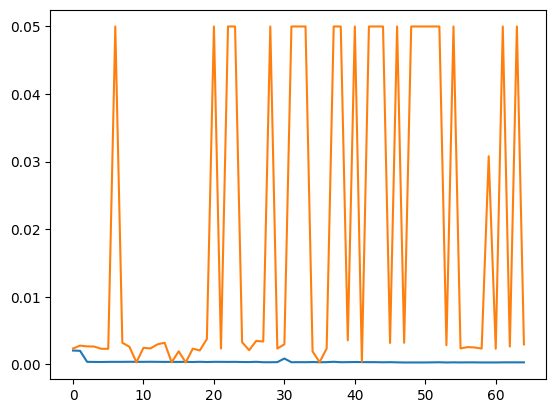

In [38]:
import matplotlib.pyplot as plt

plt.plot(coev_gep_history)
plt.plot(coev_de_history)
plt.show()

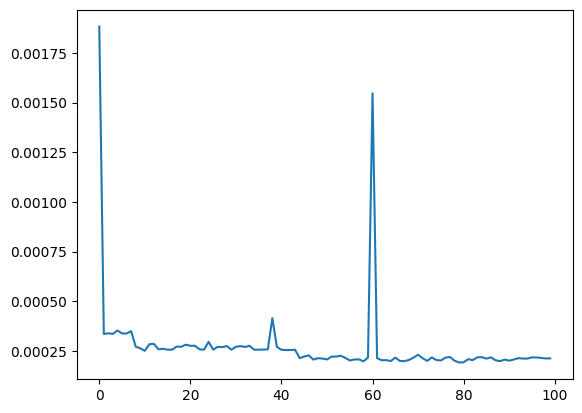

In [39]:
only_gep_history = [x if int(x) != 1 else 0.05 for x in only_gep_history]

plt.plot(only_gep_history)
plt.show()

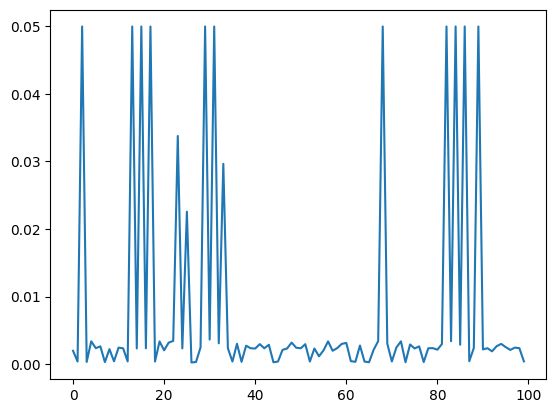

In [40]:
only_de_history = [x if int(x) != 1 else 0.05 for x in only_de_history]

plt.plot(only_de_history)
plt.show()